In [1]:
!pip3 install torch torchvision torchaudio onnx onnxruntime pillow fastapi uvicorn python-multipart

   ---------------------------------------- 0.0/15.9 MB ? eta -:--:--
   ---------------- ----------------------- 6.6/15.9 MB 33.9 MB/s eta 0:00:01
   --------------------------------- ------ 13.4/15.9 MB 33.0 MB/s eta 0:00:01
   ---------------------------------------- 15.9/15.9 MB 31.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   ----------------------- ---------------- 7.3/12.7 MB 36.4 MB/s eta 0:00:01
   ---------------------------------------- 12.7/12.7 MB 31.9 MB/s eta 0:00:00

   -------- -------------------------------  2/10 [pyreadline3]
   ------------ ---------------------------  3/10 [onnx]
   ------------ ---------------------------  3/10 [onnx]
   ------------ ---------------------------  3/10 [onnx]
   ------------ ---------------------------  3/10 [onnx]
   ------------ ---------------------------  3/10 [onnx]
   ------------ ---------------------------  3/10 [onnx]
   ------------ ---------------------------  3/10 [onnx]
   

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as TUtils
import torchvision.transforms as T
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import pathlib
import onnxruntime as ort
import io
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
import nest_asyncio
import uvicorn

In [13]:
device = torch.accelerator.current_acceleartor() if torch.accelerator.is_available() else "cpu"

In [94]:
data_transforms = T.Compose([
    T.Resize((32, 32)),  # Resize images to fit the network
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = datasets.ImageFolder(root='data/train', transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

testset = datasets.ImageFolder(root='data/test', transform=transform)

testloader = DataLoader(testset, batch_size=batch_size,
                       shuffle=False, num_workers=0)

# Redefine classes as locations instead of objects
#location_classes = (
    #'New York', 'Paris', 'Tokyo', 'London',
    #'Sydney', 'Dubai', 'Rio', 'Cape Town', 'Venice', 'Hong Kong'
#)
location_classes = trainset.classes

In [101]:
class LocationNetwork(nn.Module):
    def __init__(self, num_classes):
        super(LocationNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Input: 3 channels (RGB)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Add a print statement in forward() to check dimensions before flattening
        
        # Calculate the correct input size for the first fully connected layer
        # If your input images are 128x128x3, after two 2x2 max pooling layers:
        # 128 -> 64 -> 32
        # So feature map size would be 32x32 with 32 channels: 32*32*32 = 32768
        self.fc1 = nn.Linear(32 * 32 * 32, 512)  # Adjust these numbers based on your input size
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Print input shape for debugging
        
        # Apply convolution layers
        x = self.pool1(self.relu1(self.conv1(x)))
        
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Flatten the output for the fully connected layer
        # Store the batch size
        batch_size = x.size(0)
        
        # Calculate the feature dimensions
        feature_size = x.size(1) * x.size(2) * x.size(3)
        print(f"Feature size before flattening: {feature_size}")
        
        # Dynamically reshape based on the actual dimensions
        x = x.view(batch_size, -1)
        print(f"After flattening: {x.shape}")
        
        # Adjust the first fully connected layer dynamically
        if not hasattr(self, 'fc1') or self.fc1.in_features != x.size(1):
            self.fc1 = nn.Linear(x.size(1), 512).to(x.device)
            print(f"Adjusted fc1 input features to: {x.size(1)}")
        
        # Apply fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [102]:
locationNN = LocationNetwork(len(trainset.classes)).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(LocationNN.parameters(), lr=0.009, momentum=0.9)

In [103]:
def train(train_loader: DataLoader, model: nn.Module, criterion: nn.Module, optimizer: torch.optim):
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [107]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = locationNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [111]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = locationNN(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{location_classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  campagne campagne campagne campagne


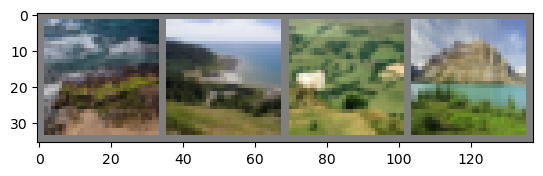

plage plage campagne montagne


In [113]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{location_classes[labels[j]]:5s}' for j in range(batch_size)))

In [114]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Done!


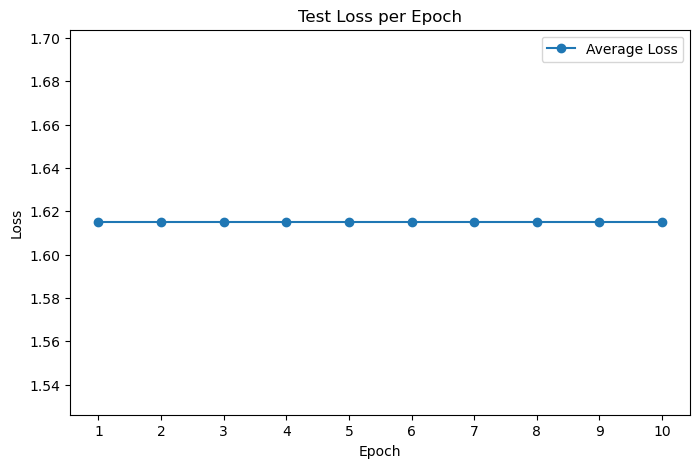

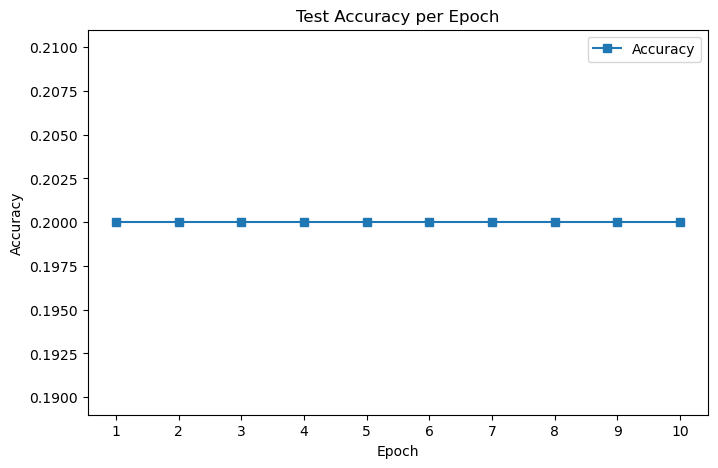

Accuracy for class: campagne is 100.0 %
Accuracy for class: foret is 0.0 %
Accuracy for class: montagne is 0.0 %
Accuracy for class: plage is 0.0 %
Accuracy for class: ville is 0.0 %


In [119]:
epochs = 10
test_losses = []
test_accuracies = []

for t in range(epochs):
    test_losses.append(test(testloader, locationNN, criterion)[0])
    test_accuracies.append(test(testloader, locationNN, criterion)[1])
print("Test Done!")

# Plot loss per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_losses, label='Average Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss per Epoch')
plt.legend()
plt.xticks(range(1, epochs+1))
plt.show()

# Plot accuracy per epoch
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), test_accuracies, label='Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.xticks(range(1, epochs+1))
plt.show()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in location_classes}
total_pred = {classname: 0 for classname in location_classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = locationNN(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[location_classes[label]] += 1
            total_pred[location_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [121]:
PATH = './model/location_recognition.pth'
torch.save(locationNN.state_dict(), PATH)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = LocationNetwork(len(trainset.classes), input_size=32)
model.load_state_dict(torch.load("model/location_recognition.pth"))

# Exemple d'entrée factice avec les bonnes dimensions [batch_size, channels, height, width]
dummy_input = torch.randn(1, 3, 32, 32)

# Export du modèle vers ONNX
torch.onnx.export(
    model,
    dummy_input,
    "location_recognition.onnx",
    input_names=["input"],
    output_names=["output"],
    opset_version=11,
    do_constant_folding=True,
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print("✅ Modèle exporté avec succès en location_recognition.onnx")

In [ ]:
session = ort.InferenceSession("location_recognition.onnx")
input_name = session.get_inputs()[0].name

def preprocess(image: Image.Image) -> np.ndarray:
    image = image.resize((32, 32))  
    image = np.array(image).astype(np.float32) / 255.0

    if image.ndim == 2:
        image = np.stack([image] * 3, axis=-1) 

    image = image.transpose(2, 0, 1) 

    mean = np.array([0.5, 0.5, 0.5]).reshape(3, 1, 1)
    std = np.array([0.5, 0.5, 0.5]).reshape(3, 1, 1)
    image = (image - mean) / std

    image = np.expand_dims(image, axis=0)
    return image

app = FastAPI()

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    try:
        content = await file.read()
        image = Image.open(io.BytesIO(content)).convert("RGB")
        input_tensor = preprocess(image)

        outputs = session.run(None, {input_name: input_tensor})
        prediction = np.argmax(outputs[0])
        predicted_label = class_names[prediction] if prediction < len(class_names) else "Inconnu"

        return JSONResponse(content={"prediction": predicted_label})
    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})

nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)

#Test du modèle côté back
image = Image.open("miami.PNG").convert("RGB")
input_tensor = preprocess(image)
output = session.run(None, {input_name: input_tensor})
print("Prédiction :", class_names[np.argmax(output[0])])